In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout,Flatten

In [3]:
path = os.path.abspath("result_BTC.csv")

In [4]:
bit_data_close=pd.read_csv(path,index_col='open_time',parse_dates=["open_time"])[['close']]

In [8]:
bit_data_close.head(5)

,close
open_time,
2018-03-22 00:00:00,9023.07
2018-03-22 01:00:00,9067.43
2018-03-22 02:00:00,9049.96
2018-03-22 03:00:00,9017.01
2018-03-22 04:00:00,9030.00


In [9]:
bit_data_close.shape

(26241, 1)

In [10]:
bit_data_close.isnull().sum()

close    0
dtype: int64

In [11]:
train_size = int(0.99*(len(bit_data_close)))
close_train=bit_data_close.iloc[:train_size]          
close_test=bit_data_close.iloc[len(close_train):]                  #test set
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)           #reshape the train data
close_train.shape   

(25978, 1)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))               #standardlize data
close_scaled=scaler.fit_transform(close_train)         #{x_i - u}/sigma
close_scaled.shape

(25978, 1)

In [13]:
# process train set: each y include 24 characteristics 
timestep=24
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) 
print("x_train shape= ",x_train.shape)                       
print("y_train shape= ",y_train.shape)                      

x_train shape=  (25954, 24, 1)
y_train shape=  (25954,)


In [14]:
#RNN
regressor=Sequential()
#the first layer
regressor.add(SimpleRNN(128,activation="relu",input_shape=(x_train.shape[1],1),return_sequences=True))
# return_sequences:default is false.whcih means return to the output of the last stride. If true,return to the output of the all stride in the last layer.
# hidden states: 128
regressor.add(Dropout(0.25))   #not work in 25% situation（avoid overfit）
###
#the second layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#the third layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#the fourth layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
###
#the fifth layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#multi-dimension- one dimension
regressor.add(Flatten())
#output
regressor.add(Dense(1))     #one dimension

regressor.compile(optimizer="adam",loss="mean_squared_error")  
regressor.fit(x_train,y_train,epochs=100,batch_size=64)       #100 epoch，64 samples each epoch

Epoch 1/100
406/406 [==============================] - 122s 290ms/step - loss: 0.0022
Epoch 2/100
406/406 [==============================] - 116s 285ms/step - loss: 3.3842e-04
Epoch 3/100
406/406 [==============================] - 116s 284ms/step - loss: 2.8824e-04
Epoch 4/100
406/406 [==============================] - 116s 286ms/step - loss: 2.3841e-04
Epoch 5/100
406/406 [==============================] - 116s 286ms/step - loss: 3.3621e-04
Epoch 6/100
406/406 [==============================] - 115s 284ms/step - loss: 1.8081e-04
Epoch 7/100
406/406 [==============================] - 115s 284ms/step - loss: 1.8255e-04
Epoch 8/100
406/406 [==============================] - 115s 284ms/step - loss: 1.7707e-04
Epoch 9/100
406/406 [==============================] - 115s 284ms/step - loss: 2.0007e-04
Epoch 10/100
406/406 [==============================] - 115s 284ms/step - loss: 2.1561e-04
Epoch 11/100
406/406 [==============================] - 115s 283ms/step - loss: 2.4129e-04
Epoch 12/100

In [15]:
#predict
inputs=bit_data_close[len(bit_data_close)-len(close_test)-timestep:]           #input is the characteristic in test set
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)                           

x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
x_test.shape                                                  

predicted_data=regressor.predict(x_test)                      #using the trained model to predict
predicted_data1=scaler.inverse_transform(predicted_data)       

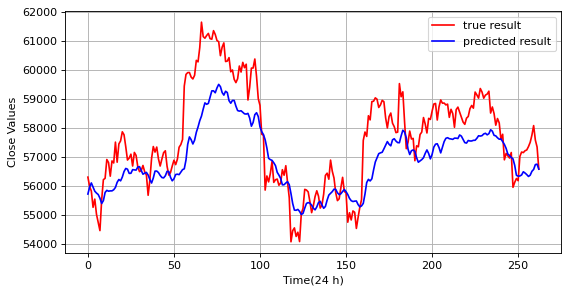

In [16]:
data_test=np.array(close_test)                           #true price
data_test=data_test.reshape(len(data_test),1)
#plot show the relationship between the true price and the predicted price
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data1,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(24 h)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [17]:
# RNN Correlation coefficient 
test_series = pd.Series(data_test.flatten().tolist())  
predicted_series1 = pd.Series(predicted_data1.flatten().tolist())
print(test_series.corr(predicted_series1))

0.8903297883852385


In [3]:
#RNN for BNB
bnb_data=pd.read_csv("result_BNB.csv",index_col='open_time',parse_dates=["open_time"])[["close"]]
print("bnb_data: ",bnb_data.shape)
bnb_data.head(5)

bnb_data:  (26241, 1)


,close
open_time,
2018-03-22 00:00:00,10.2678
2018-03-22 01:00:00,10.2300
2018-03-22 02:00:00,10.1498
2018-03-22 03:00:00,10.0805
2018-03-22 04:00:00,10.4000


In [4]:
bnb_data.isnull().sum()

close    0
dtype: int64

In [5]:
train_size_bnb=int(0.99*(len(bnb_data)))
close_train_bnb=bnb_data.iloc[:train_size_bnb]          
close_test_bnb=bnb_data.iloc[len(close_train_bnb):]    
close_train_bnb=np.array(close_train_bnb)
close_train_bnb=close_train_bnb.reshape(close_train_bnb.shape[0],1)  
print ("close_train_bnb: ", close_train_bnb.shape )  

close_train_bnb:  (25978, 1)


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))               
close_scaled_bnb=scaler.fit_transform(close_train_bnb)         #standardlize data

In [7]:
# process train set: each y include 24 characteristics 
timestep=24
x_train_bnb=[]
y_train_bnb=[]

for i in range(timestep,close_scaled_bnb.shape[0]):
    x_train_bnb.append(close_scaled_bnb[i-timestep:i,0])
    y_train_bnb.append(close_scaled_bnb[i,0])

x_train_bnb,y_train_bnb=np.array(x_train_bnb),np.array(y_train_bnb)
x_train_bnb=x_train_bnb.reshape(x_train_bnb.shape[0],x_train_bnb.shape[1],1) 
print("x_train_bnb shape= ",x_train_bnb.shape)                       
print("y_train_bnb shape= ",y_train_bnb.shape)     

x_train_bnb shape=  (25954, 24, 1)
y_train_bnb shape=  (25954,)


In [8]:
# RNN
regressor_bnb=Sequential()
#the first layer
regressor_bnb.add(SimpleRNN(128,activation="relu",input_shape=(x_train_bnb.shape[1],1),return_sequences=True))
# return_sequences:default is false.whcih means return to the output of the last stride. If true,return to the output of the all stride in the last layer.
# hidden states: 128
regressor_bnb.add(Dropout(0.25))   #not work in 25% situation（avoid overfit）
###
#the second layer
regressor_bnb.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor_bnb.add(Dropout(0.25))
#the third layer
regressor_bnb.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor_bnb.add(Dropout(0.25))
#the fourth layer
regressor_bnb.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor_bnb.add(Dropout(0.25))
###
#the fifith layer
regressor_bnb.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor_bnb.add(Dropout(0.25))
#multi-dimension- one dimension
regressor_bnb.add(Flatten())
#output
regressor_bnb.add(Dense(1))     #one dimension

regressor_bnb.compile(optimizer="adam",loss="mean_squared_error")  
regressor_bnb.fit(x_train_bnb,y_train_bnb,epochs=50,batch_size=64)       #50 epochs，64 samples each epoch

Epoch 1/50
406/406 [==============================] - 38s 85ms/step - loss: 0.0011
Epoch 2/50
406/406 [==============================] - 39s 96ms/step - loss: 2.9602e-04
Epoch 3/50
406/406 [==============================] - 36s 88ms/step - loss: 3.1822e-04
Epoch 4/50
406/406 [==============================] - 36s 88ms/step - loss: 2.4864e-04
Epoch 5/50
406/406 [==============================] - 36s 89ms/step - loss: 1.9368e-04
Epoch 6/50
406/406 [==============================] - 36s 88ms/step - loss: 2.1456e-04
Epoch 7/50
406/406 [==============================] - 36s 89ms/step - loss: 2.1217e-04
Epoch 8/50
406/406 [==============================] - 40s 98ms/step - loss: 1.8442e-04
Epoch 9/50
406/406 [==============================] - 42s 104ms/step - loss: 1.5729e-04
Epoch 10/50
406/406 [==============================] - 38s 94ms/step - loss: 1.4321e-04
Epoch 11/50
406/406 [==============================] - 36s 90ms/step - loss: 1.1422e-04
Epoch 12/50
406/406 [=======================

In [9]:
#Predict
inputs_bnb=bnb_data[len(bnb_data)-len(close_test_bnb)-timestep:]           #input is the characteristic in test set
inputs_bnb=inputs_bnb.values.reshape(-1,1)
inputs_bnb=scaler.transform(inputs_bnb)                            

x_test_bnb=[]
for i in range(timestep,inputs_bnb.shape[0]):
    x_test_bnb.append(inputs_bnb[i-timestep:i,0])
x_test_bnb=np.array(x_test_bnb)
x_test_bnb=x_test_bnb.reshape(x_test_bnb.shape[0],x_test_bnb.shape[1],1)
x_test_bnb.shape    

predicted_data_bnb=regressor_bnb.predict(x_test_bnb)                      #using the trained model to predict
predicted_data_bnb=scaler.inverse_transform(predicted_data_bnb)    

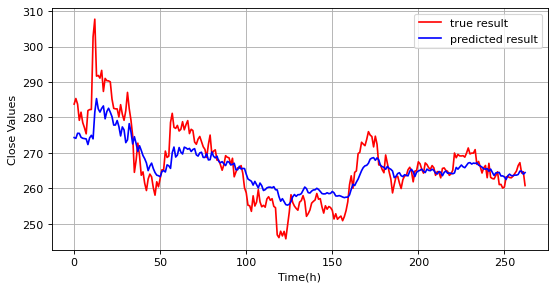

In [10]:
data_test_bnb=np.array(close_test_bnb)                           
data_test_bnb=data_test_bnb.reshape(len(data_test_bnb),1)
#plot show the relationship between the true price and the predicted price
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test_bnb,color="r",label="true result")
plt.plot(predicted_data_bnb,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(h)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [12]:
#BNB RNN Correlation coefficient 
test_series_bnb = pd.Series(data_test_bnb.flatten().tolist())  
predicted_series_bnb = pd.Series(predicted_data_bnb.flatten().tolist())
print(test_series_bnb.corr(predicted_series_bnb))

0.9201359954367712


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout,Flatten

In [3]:
#RNN for ETH
eth_data=pd.read_csv("result_ETH.csv",index_col='open_time',parse_dates=["open_time"])[["close"]]
print("eth_data: ",eth_data.shape)
eth_data.head(5)

eth_data:  (26241, 1)


,close
open_time,
2018-03-22 00:00:00,570.72
2018-03-22 01:00:00,572.78
2018-03-22 02:00:00,573.83
2018-03-22 03:00:00,569.58
2018-03-22 04:00:00,570.00


In [4]:
eth_data.isnull().sum()

close    0
dtype: int64

In [6]:
train_size_eth=int(0.99*(len(eth_data)))
close_train_eth=eth_data.iloc[:train_size_eth]          
close_test_eth=eth_data.iloc[len(close_train_eth):]    
close_train_eth=np.array(close_train_eth)
close_train_eth=close_train_eth.reshape(close_train_eth.shape[0],1)  
print ("close_train_eth: ", close_train_eth.shape )  

close_train_eth:  (25978, 1)


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))               
close_scaled_eth=scaler.fit_transform(close_train_eth)         #standardlize data

In [9]:
# process train set: each y include 24 characteristics 
timestep=24
x_train_eth=[]
y_train_eth=[]

for i in range(timestep,close_scaled_eth.shape[0]):
    x_train_eth.append(close_scaled_eth[i-timestep:i,0])
    y_train_eth.append(close_scaled_eth[i,0])

x_train_eth,y_train_eth=np.array(x_train_eth),np.array(y_train_eth)
x_train_eth=x_train_eth.reshape(x_train_eth.shape[0],x_train_eth.shape[1],1) 
print("x_train_eth shape= ",x_train_eth.shape)                       
print("y_train_eth shape= ",y_train_eth.shape)    


x_train_eth shape=  (25954, 24, 1)
y_train_eth shape=  (25954,)


In [10]:
#RNN
regressor_eth=Sequential()
#the first layer
regressor_eth.add(SimpleRNN(128,activation="relu",input_shape=(x_train_eth.shape[1],1),return_sequences=True))
# return_sequences:default is false.whcih means return to the output of the last stride. If true,return to the output of the all stride in the last layer.
# hidden states: 128
regressor_eth.add(Dropout(0.25))   
###
#the second layer
regressor_eth.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor_eth.add(Dropout(0.25))
#the third layer
regressor_eth.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor_eth.add(Dropout(0.35))
#the fourth layer
regressor_eth.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor_eth.add(Dropout(0.25))
###
#the fifth layer
regressor_eth.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor_eth.add(Dropout(0.25))
#multi-dimension- one dimension
regressor_eth.add(Flatten())
#output
regressor_eth.add(Dense(1))     #one dimension

regressor_eth.compile(optimizer="adam",loss="mean_squared_error")  
regressor_eth.fit(x_train_eth,y_train_eth,epochs=20,batch_size=64)       

Epoch 1/20
406/406 [==============================] - 77s 180ms/step - loss: 0.0103
Epoch 2/20
406/406 [==============================] - 80s 198ms/step - loss: 2.9244e-04
Epoch 3/20
406/406 [==============================] - 79s 195ms/step - loss: 2.9969e-04
Epoch 4/20
406/406 [==============================] - 78s 192ms/step - loss: 2.9447e-04
Epoch 5/20
406/406 [==============================] - 80s 197ms/step - loss: 2.4181e-04
Epoch 6/20
406/406 [==============================] - 86s 211ms/step - loss: 2.1557e-04
Epoch 7/20
406/406 [==============================] - 80s 198ms/step - loss: 2.0143e-04
Epoch 8/20
406/406 [==============================] - 81s 200ms/step - loss: 1.8409e-04
Epoch 9/20
406/406 [==============================] - 81s 199ms/step - loss: 1.9376e-040s - loss: 1.9377
Epoch 10/20
406/406 [==============================] - 81s 198ms/step - loss: 1.7290e-04
Epoch 11/20
406/406 [==============================] - 80s 198ms/step - loss: 1.5988e-04
Epoch 12/20
406/4

In [11]:
#Predict
inputs_eth=eth_data[len(eth_data)-len(close_test_eth)-timestep:]           #input is the characteristic in test set
inputs_eth=inputs_eth.values.reshape(-1,1)
inputs_eth=scaler.transform(inputs_eth)                            

x_test_eth=[]
for i in range(timestep,inputs_eth.shape[0]):
    x_test_eth.append(inputs_eth[i-timestep:i,0])
x_test_eth=np.array(x_test_eth)
x_test_eth=x_test_eth.reshape(x_test_eth.shape[0],x_test_eth.shape[1],1)
x_test_eth.shape    

predicted_data_eth=regressor_eth.predict(x_test_eth)                      #using the trained model to predict
predicted_data_eth=scaler.inverse_transform(predicted_data_eth)  


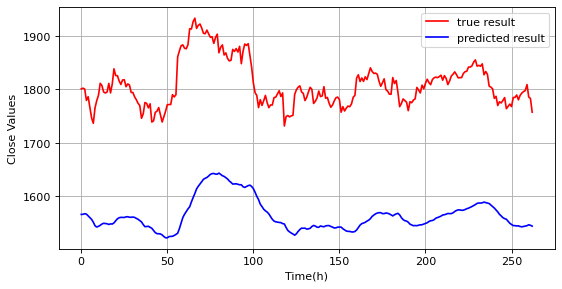

In [12]:
data_test_eth=np.array(close_test_eth)                           
data_test_eth=data_test_eth.reshape(len(data_test_eth),1)
#plot show the relationship between the true price and the predicted price
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test_eth,color="r",label="true result")
plt.plot(predicted_data_eth,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(h)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()


In [13]:
#ETH RNN Correlation coefficient 
test_series_eth = pd.Series(data_test_eth.flatten().tolist())  
predicted_series_eth = pd.Series(predicted_data_eth.flatten().tolist())
print(test_series_eth.corr(predicted_series_eth))


0.7604387195939123
